In [1]:
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- 1. Set Global Random Seed ---
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print(f"✓ Random seed set to {RANDOM_SEED} for reproducibility")


✓ Random seed set to 42 for reproducibility


 Data Loading & Fair Split

In [2]:
from sklearn.model_selection import train_test_split

# --- 2. Load Data ---
# Ensure the file is named correctly (e.g., 'train_dataset.csv' or 'Smoker_Status.csv')
filename = 'train.csv'# <--- CHANGE THIS to your actual filename
try:
    df = pd.read_csv(r"C:\Users\Kartikey\ml_project\data\smoking\train.csv")
    print(f"✓ Dataset '{filename}' loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: '{filename}' not found. Please upload the file.")

# --- 3. Clean Data ---
# Drop 'id' if it exists, as it's not a feature
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("  - Dropped 'id' column.")

# Separate Features and Target
# Target column is usually 'smoking' in this dataset
target_col = 'smoking' 
X = df.drop(target_col, axis=1)
y = df[target_col]

# --- 4. Handle Missing Values ---
if y.isnull().any():
    print(f"  - Removing {y.isnull().sum()} rows with missing targets...")
    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

# --- 5. Create Fixed Train/Test Split ---
# 80% Train (for CV), 20% Holdout Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_SEED
)

print("-" * 40)
print(f"Data Splitting Complete:")
print(f"  Training Set: {X_train.shape[0]} samples")
print(f"  Test Set:     {X_test.shape[0]} samples")
print("-" * 40)


✓ Dataset 'train.csv' loaded successfully.
----------------------------------------
Data Splitting Complete:
  Training Set: 31187 samples
  Test Set:     7797 samples
----------------------------------------


Preprocessing & CV Strategy

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# --- 6. Preprocessing Pipeline ---
# Identify binary columns automatically (columns with only 2 unique values like 0 and 1)
# 'dental caries' is typically the main binary one.
binary_cols = [col for col in X.columns if X[col].nunique() == 2 and set(X[col].unique()) <= {0, 1}]
continuous_cols = [col for col in X.columns if col not in binary_cols]

print(f"Detected Binary Features (Passthrough): {binary_cols}")
print(f"Detected Continuous Features (Scaled): {len(continuous_cols)} columns")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', 'passthrough', binary_cols)
    ]
)

# --- 7. Cross-Validation Strategy ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


Detected Binary Features (Passthrough): ['dental caries']
Detected Continuous Features (Scaled): 21 columns


Model Definitions & Training Loop

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# --- 8. Define Models ---

# A. Logistic Regression
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='saga', 
        max_iter=500, 
        n_jobs=1, 
        random_state=RANDOM_SEED
    ))
])

# B. Linear SVM
svm_linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        dual=False, 
        max_iter=1000, 
        random_state=RANDOM_SEED
    ))
])

# C. Optimized MLP
# Kept (128, 64) as it's a robust default, though (64, 32) might suffice for this simpler task.
mlp_opt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(128, 64), 
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        early_stopping=True,
        max_iter=300, 
        random_state=RANDOM_SEED
    ))
])

models = {
    "Logistic Regression": log_reg_pipeline,
    "SVM (Linear)": svm_linear_pipeline,
    "MLP (Optimized)": mlp_opt_pipeline
}

results = {'Model': [], 'Accuracy': [], 'F1-Macro': [], 'Time (s)': []}

# --- 9. Evaluation Loop ---
print(f"{'Model':<20} | {'Status':<15}")
print("-" * 50)

for name, pipeline in models.items():
    print(f"{name:<20} | Training...", end='\r')
    start_time = time.time()
    
    # Run CV
    acc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    elapsed = time.time() - start_time
    
    results['Model'].append(name)
    results['Accuracy'].append(acc_scores.mean())
    results['F1-Macro'].append(f1_scores.mean())
    results['Time (s)'].append(elapsed)
    
    print(f"{name:<20} | Done in {elapsed:.1f}s (Acc: {acc_scores.mean():.4f})")


Model                | Status         
--------------------------------------------------
Logistic Regression  | Done in 4.8s (Acc: 0.7242)
SVM (Linear)         | Done in 1.7s (Acc: 0.7242)
MLP (Optimized)      | Done in 9.2s (Acc: 0.7535)


RBF SVM (Subset or Full)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# --- 10. RBF SVM ---
# Check data size. If < 50k, use full data. If > 50k, use subset.
total_train_samples = X_train.shape[0]
subset_size = 50000 

if total_train_samples > subset_size:
    print(f"\nTraining RBF SVM on SUBSET of {subset_size} samples (Dataset is large)...")
    sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=RANDOM_SEED)
    for train_idx, _ in sss.split(X_train, y_train):
        X_sub, y_sub = X_train.iloc[train_idx], y_train.iloc[train_idx]
else:
    print(f"\nTraining RBF SVM on FULL Training set ({total_train_samples} samples)...")
    X_sub, y_sub = X_train, y_train

rbf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf', 
        C=10, 
        gamma='scale', 
        cache_size=2000, 
        random_state=RANDOM_SEED
    ))
])

start_rbf = time.time()
rbf_pipeline.fit(X_sub, y_sub)
train_time = time.time() - start_rbf

print("Predicting RBF on Test Set...")
y_pred_rbf = rbf_pipeline.predict(X_test) 
pred_time = time.time() - start_rbf - train_time

rbf_acc = accuracy_score(y_test, y_pred_rbf)
rbf_f1 = f1_score(y_test, y_pred_rbf, average='macro')

print(f"SVM (RBF)            | Done. Total Time: {train_time+pred_time:.1f}s (Acc: {rbf_acc:.4f})")

results['Model'].append("SVM (RBF)")
results['Accuracy'].append(rbf_acc)
results['F1-Macro'].append(rbf_f1)
results['Time (s)'].append(train_time + pred_time)



Training RBF SVM on FULL Training set (31187 samples)...
Predicting RBF on Test Set...
SVM (RBF)            | Done. Total Time: 38.7s (Acc: 0.7575)


 Comparison & Visualization


Final Model Comparison:


,Model,Accuracy,F1-Macro,Time (s)
3,SVM (RBF),0.7575,0.7379,38.6713
2,MLP (Optimized),0.7535,0.7348,9.1776
0,Logistic Regression,0.7242,0.6961,4.8369
1,SVM (Linear),0.7242,0.6968,1.6958


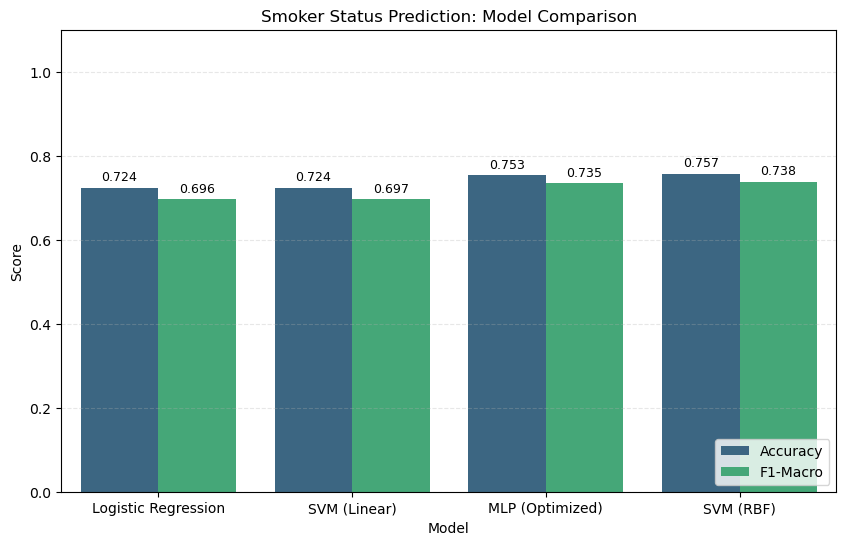

In [6]:
# --- 11. Final Results Table ---
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
pd.options.display.float_format = '{:,.4f}'.format
display(results_df.sort_values(by='Accuracy', ascending=False))

# Visualization
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
metrics_only = results_melted[results_melted['Metric'].isin(['Accuracy', 'F1-Macro'])]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=metrics_only, x="Model", y="Score", hue="Metric", palette="viridis")

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.title("Smoker Status Prediction: Model Comparison")
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


Final Validation

In [7]:
# --- 12. Final Validation (Optimized MLP) ---
print("Running Final Evaluation on Holdout Test Set for Best Model (MLP)...")

start_final = time.time()
mlp_opt_pipeline.fit(X_train, y_train)
fit_time = time.time() - start_final

final_preds = mlp_opt_pipeline.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds, average='macro')

print(f"\n{'='*40}")
print(f"FINAL RESULT: Optimized MLP")
print(f"{'='*40}")
print(f"Accuracy on Holdout Test: {final_acc:.2%}")
print(f"F1-Macro on Holdout Test: {final_f1:.4f}")
print(f"Refit Time:               {fit_time:.1f}s")
print(f"{'='*40}")


Running Final Evaluation on Holdout Test Set for Best Model (MLP)...

FINAL RESULT: Optimized MLP
Accuracy on Holdout Test: 75.80%
F1-Macro on Holdout Test: 0.7413
Refit Time:               3.3s
